# Train and deploy models using SageMaker
In this notebook we'll see how we can train and deploy a segmentation model using SageMaker. For ths work I use the [MONAI](https://monai.io/) open source framework for processing of the medical images and for the segmentation models. [PyTorch Lightning](https://www.pytorchlightning.ai/) is used to organizing the code needed for training the models. In the examples shown in this notebook we'll use the [UNet](https://arxiv.org/abs/1505.04597) architecture, which is a good starting point for most segmentation tasks.

This notebook includes:
- Data transformation pipeline and augmentation demonstration using MONAI
- How PyTorch Lightning is used to organize the model training code
- Demonstration of how to train PyTorch models in different SageMaker modes:
    - Fully local training on local SageMaker Docker container
    - Submit training job from notebook running on local machine to SageMaker instance
    - Submitting training job from SageMaker Notebook
- Running SageMaker hyperparameter tuning
- Deploying the best model

Note that the data will be downloaded and organized in case you didn't run the first notebook. These steps will be skipped if you already did this.

## Setup

### Install packages
If running on a SageMaker Notebook, uncomment the cell below and run it to install the additional packages required.

In [ ]:
#!pip install GitPython monai[all]==0.9.1 wandb==0.12.21 pytorch_lightning==1.6.5 natsort

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import os
import sys

import git
from monai.transforms import (
    Activations, AsDiscrete, LoadImage, LoadImaged, LoadImageD, EnsureChannelFirstd,
    Resized, EnsureType, EnsureTyped, Compose, ScaleIntensityd, RandFlipd, ToDeviced,
    NormalizeIntensityd, RandRotated, RandRotated, RandSpatialCropd, ScaleIntensityRanged, RandScaleIntensityd, RandShiftIntensityd, RandGaussianNoised,
    ScaleIntensityRange, CenterSpatialCrop, EnsureType, AsChannelFirst
)
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import sagemaker
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from tqdm.auto import tqdm
import wandb
import yaml

In [7]:
sys.path.append('./../')
from src.data import create_kaggle_token_file, setup_brain_mri_dataset, extract_patient_filepaths, extract_dataset_filepaths, upload_data_to_s3
from src.utils import set_sagemaker_settings, generate_wandb_api_key
from src.visualize import plot_monai_transformed_data, plot_monai_pipeline_data, plot_endpoint_prediction
from sagemaker_src.brain_datamodule import BrainMRIData, monai_transformations
from sagemaker_src.brain_model import BrainMRIModel

### Import configuration file
The `config.yaml` file contains some import parameters that we will use throughout the notebook. For instance, it includes `DATA_DIR`, which specifies where we will store the data locally. Currently this is set to `./data` (i.e. a folder named `data` will be created inside the folder where you are running this notebook), but you can choose a different location if you wish.

In [5]:
with open("./../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config

{'DATA_DIR': 'data',
 'DATA_ZIP_FILENAME': 'lgg-mri-segmentation.zip',
 'DUMMY_IAM_ROLE': 'arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-20200101T000001',
 'KAGGLE_DATASET': 'mateuszbuda/lgg-mri-segmentation',
 'RUN_MODE': 'sagemaker',
 'S3_BUCKET_NAME': 'sagemaker-brain-mri'}

Use the Python `git` package to determine the root locaton of the repository and the full path to the root data directory:

In [6]:
git_repo = git.Repo('.', search_parent_directories=True)
PROJECT_ROOT_PATH = git_repo.working_dir
DATA_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, config['DATA_DIR'])

In [12]:
DATA_ROOT_PATH

'/home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/data'

### Check data downloaded and setup
If you didn't already download and setup the datasets in the first notebook (`01_data-prep-eda.ipynb`) then you will do this now in this step. Note that if required you will be prompted to enter you Kaggle API details (see first notebook for details).

If you already downloaded the data and uploaded the datasets to an S3 bucket then the functions will skip these steps for you.

In [7]:
create_kaggle_token_file()
setup_brain_mri_dataset(data_root_path=DATA_ROOT_PATH)
upload_data_to_s3(bucket_name=config['S3_BUCKET_NAME'], local_dataset_path=os.path.join(DATA_ROOT_PATH, 'brain-mri-dataset'))

2022-08-18 12:31:26,283 Kaggle token file already created in /home/robsmith155/.kaggle/kaggle.json.
2022-08-18 12:31:26,285 Data already downloaded from Kaggle. Skipping download.
2022-08-18 12:31:26,286 Training, validation and test datasets already prepared. Skipping step.
2022-08-18 12:31:26,311 Found credentials in shared credentials file: ~/.aws/credentials
2022-08-18 12:31:33,933 Data already uploaded to s3://sagemaker-brain-mri/data. Skipping this step.


Although not required, it is recommended to use Weights and Biases to track the experiments in this project. The training functions have been built with this option. If you want to use it, you will need to create an account and then follow the instructions when the function below is run.

In [10]:
generate_wandb_api_key()

2022-08-18 12:31:54,066 Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robsmith155. Use `wandb login --relogin` to force relogin
2022-08-18 12:31:56,285 INFO: Already logged into Weights and Biases...
2022-08-18 12:31:56,287 INFO: Weights and Biases secret API key saved to /home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/sagemaker_src/secrets.env


## Data augmentation


In this project I'm making use of the [MONAI](https://monai.io/) package, which is a PyTorch-based framework for deep learning with medical data. This provides a convenient way to produce a transformation pipeline for medical data, including data loading and augmentation techniques. In this case we have our data is in the form of 2D `.tif` images, so they are relatively easy to work with. However, medical data will often come as 3D `DICOM` files which would be much more challenging without MONAI.

In this section we will see some of the transforms available in MONAI, how they work, and put together a pipeline that we will use for training. Documentation with all available transformations can be found [here](https://docs.monai.io/en/stable/transforms.html).


### Test slice
First, let's select an example MRI slice that we will use to see what the different transformations do.

In [14]:
train_patient_folders = [f.path for f in os.scandir(os.path.join(DATA_ROOT_PATH, 'brain-mri-dataset/train')) if f.is_dir()]
train_files_patient_1 = extract_patient_filepaths(train_patient_folders[0])

In [15]:
test_slice = train_files_patient_1[21]
test_slice

{'image': '/home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/data/brain-mri-dataset/train/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22.tif',
 'mask': '/home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/data/brain-mri-dataset/train/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_22_mask.tif'}

### Load data
The first step in the pipeline needs to load the image files. Since I have put the data paths to the image and mask in a dictionary, I can make use ofthe `LoadImaged` class for this. This is convenient since it allows us to easily specify which keys we want to apply the transformation to. In this case we want to load both the image and mask data, so we specify `keys=['image', 'mask']`. 

In [16]:
data = LoadImaged(keys=['image', 'mask'])(test_slice)

This outputs a new dictionary containing the data and meta-data:

In [17]:
data.keys()

dict_keys(['image', 'mask', 'image_meta_dict', 'mask_meta_dict'])

The image data is stored under the `image` key and the segmentation mask under the `mask` key:

In [18]:
data['image'].shape, data['mask'].shape

((256, 256, 3), (256, 256))

The raw data after loading the tif images is shown below.

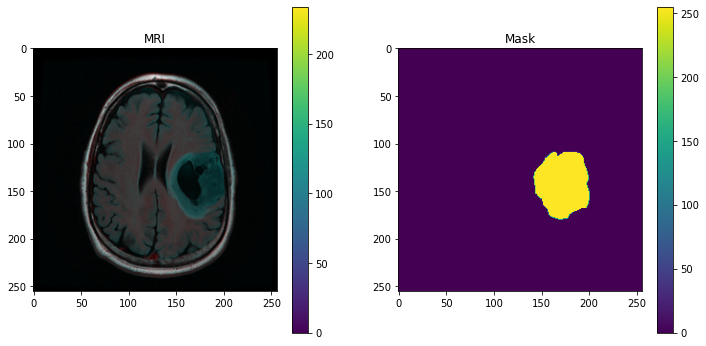

In [19]:
plot_monai_transformed_data(data, transpose=False, raw_data=True)

#### EnsureChannelFirstd
MONAI expects the channels to be in the first dimension of the data array (since it is built on top of PyTorch). Using `EnsureChannelFirstd` makes sure this is the case. 

In [21]:
data = EnsureChannelFirstd(keys=['image', 'mask'])(data)
data['image'].shape

(3, 256, 256)

So we can see that the channels are now the first dimension of the array. This doesn't affect how the data looks though, although we need to transpose the data in this case in order to plot it with Matplotlib (which expects the channels in the last axis).

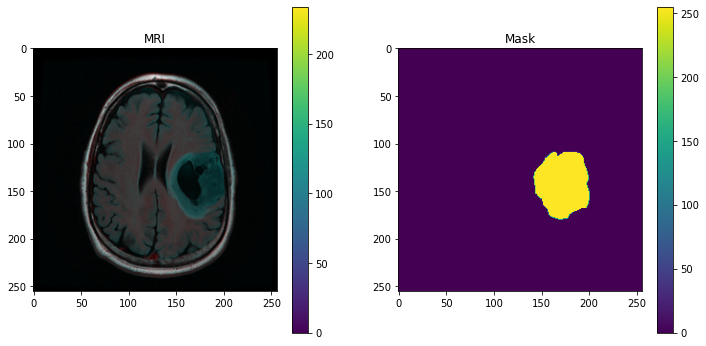

In [22]:
plot_monai_transformed_data(data)

### Horizontal flip
Flipping the data horizontally doesn't affect the meaning of the MRI scan, so we can use this as a way to help the model learn from different view points of the same input image (a tumour can occur on either side of the brain). Technically a vertical flip also doesn't change the meaning of the MRI scan. However, all of the validation and test examples are oriented vertically, so it probably makes sense to keep this consistent. We can use `RandFlipd` for this transformation.

**Note:** For the random transformations in this example workflow I set the probability to one. This is to ensure that we can see a change in the resulting data. In the actual pipeline, the probability is set this to something like 0.5, so it only happens half the time.

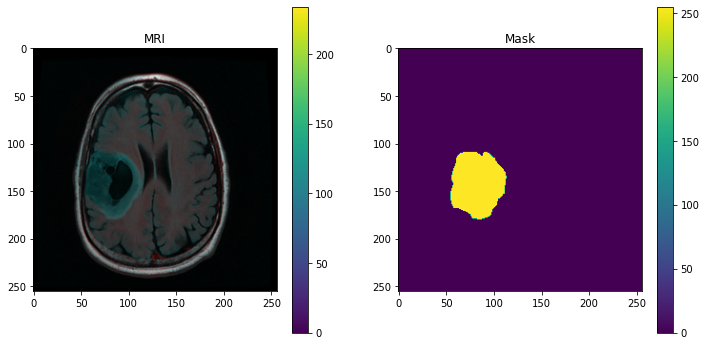

In [24]:
data = RandFlipd(keys=['image', 'mask'], spatial_axis=0, prob=1.)(data)
plot_monai_transformed_data(data)

#### Random data rotation
Here we will allow some small rotation of the input data. The MONAI transform `RandRotated` can be used for this purpose. Here I want to allow a small rotation of between -15 and 15 degrees, but note that the angle should be specified in terms of radians.

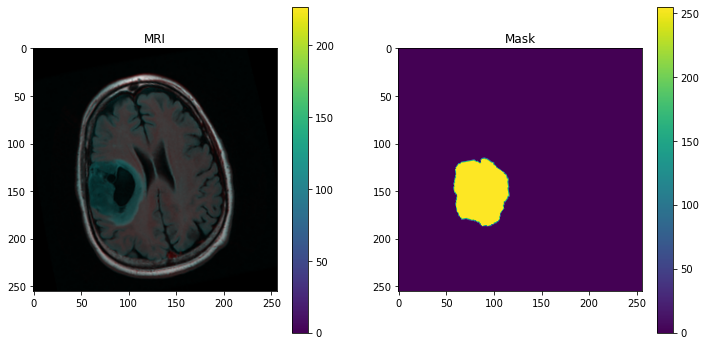

In [27]:
data = RandRotated(keys=['image', 'mask'], range_x=math.radians(15), range_y=math.radians(15), prob=1.)(data)
plot_monai_transformed_data(data)

### Random spatial crop
The spatial size of all the images is 256 x 256 pixels. Here I use the `RandSpatialCropd` class to randomly select a 224 x 224 pixel class. In many MRI images we have a lot of black space around the image, and some examples are slightly cropped anyway.

Note that in the case of the validation and test data, we will use the `CenterSpatialCropd` class to ensure that we get a consistent 224 x 224 crop.


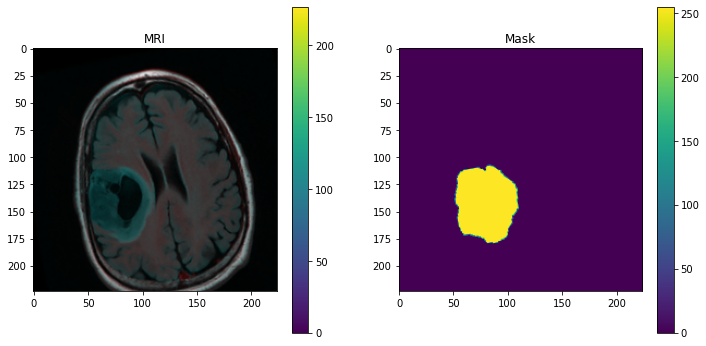

In [28]:
data = RandSpatialCropd(keys=["image", "mask"], roi_size=(224, 224), random_size=False)(data)
plot_monai_transformed_data(data)

#### Normalize data
I will also include some random perturbations of the image amplitudes, but we should probably normalize the data first. I currently have some issues normalizing with the mean and standard deviations computed in the EDA section, so for now we will just normalize the data to be in the range [0,1]. I may revisit this later to apply standarization so that the mean is 0 and standard deviation is 1.

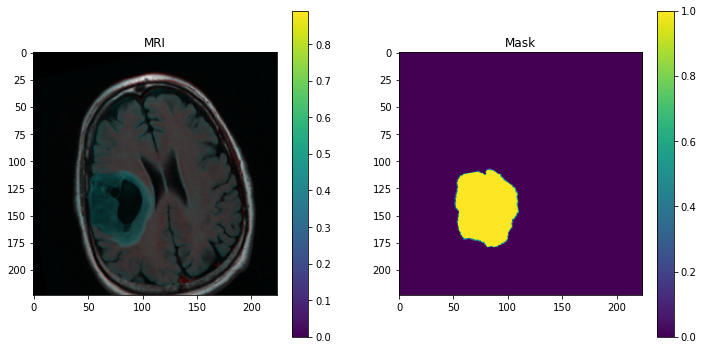

In [29]:
data = ScaleIntensityRanged(keys=['image', 'mask'], a_min=0., a_max=255., b_min=0., b_max=1.)(data)
plot_monai_transformed_data(data, transpose=True, convert_uint8=False)

Note that both scales have now been changed.
#### Random scale intensity changes
Now I'll apply some random perturbations to the amplitudes. Here we only want to apply the transformation to the image data, so we omit `mask` from the `keys` parameter in this case.


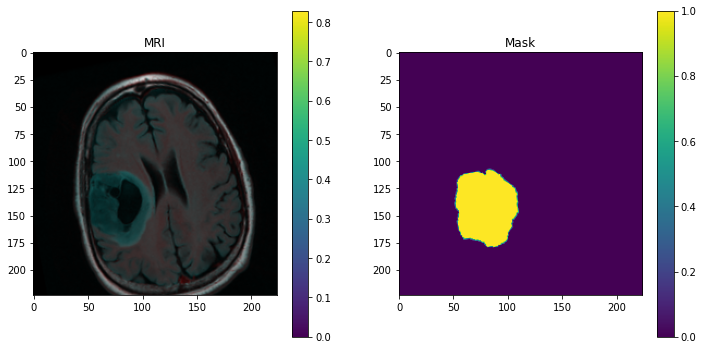

In [30]:
data = RandScaleIntensityd(keys=['image'], factors=0.1, prob=1.)(data)
plot_monai_transformed_data(data, convert_uint8=False)

#### Random shift intensity

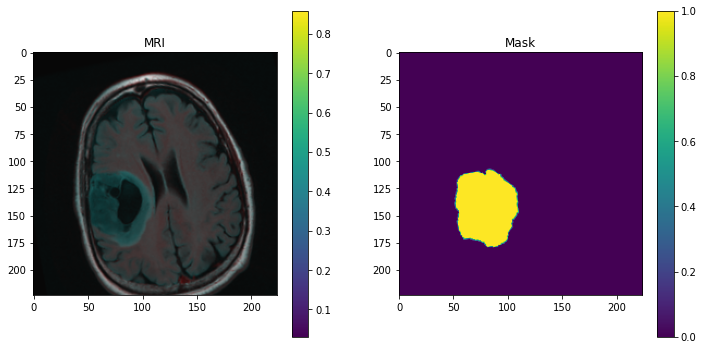

In [31]:
data = RandShiftIntensityd(keys=['image'], offsets=0.1, prob=1.)(data)
plot_monai_transformed_data(data, convert_uint8=False)

#### Add Gaussian noise

2022-08-18 12:41:35,950 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


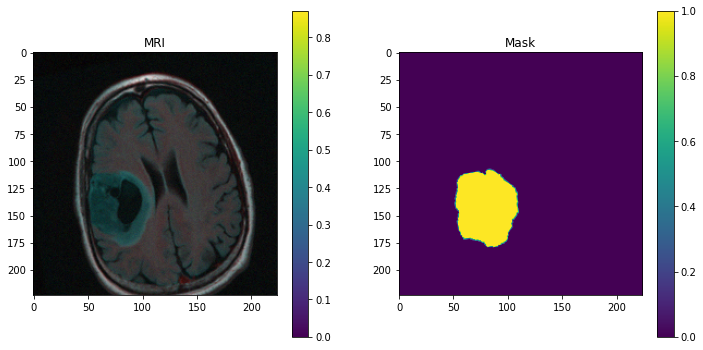

In [32]:
data = RandGaussianNoised(keys=['image'], mean=0., std=0.05, prob=1.)(data)
plot_monai_transformed_data(data, convert_uint8=False)

### Augmentation pipeline
Obviously we don't want to apply each transformation one by one like in the last section. To avoid this, MONAI provide us with the `Compose` class to allow us to put the pipeline together.

In [33]:
train_transforms = Compose([
    LoadImaged(keys=['image', 'mask']),
    EnsureChannelFirstd(keys=['image', 'mask']),
    EnsureTyped(keys=["image", "mask"]),
    RandFlipd(keys=['image', 'mask'], spatial_axis=0, prob=0.5),
    RandRotated(keys=['image', 'mask'], range_x=0.26, range_y=0.26, prob=0.5),
    ScaleIntensityRanged(keys=['image', 'mask'], a_min=0., a_max=255., b_min=0., b_max=1.),
    RandSpatialCropd(keys=["image", "mask"], roi_size=(224, 224), random_size=False),
    RandScaleIntensityd(keys=['image'], factors=0.1, prob=0.5),
    RandShiftIntensityd(keys=['image'], offsets=0.1, prob=0.5),
    RandGaussianNoised(keys=['image'], mean=0., std=0.05, prob=0.5)    
])

The `plot_monai_pipeline_data` function has been added to the `src/visualize` module and plots the original image and mask along with four different augmented views (i.e. the input image and mask is passed through the MONAI transformation pipeline four different times). An example is shown below.

2022-08-18 12:42:08,126 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-08-18 12:42:08,134 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-08-18 12:42:08,142 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2022-08-18 12:42:08,149 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


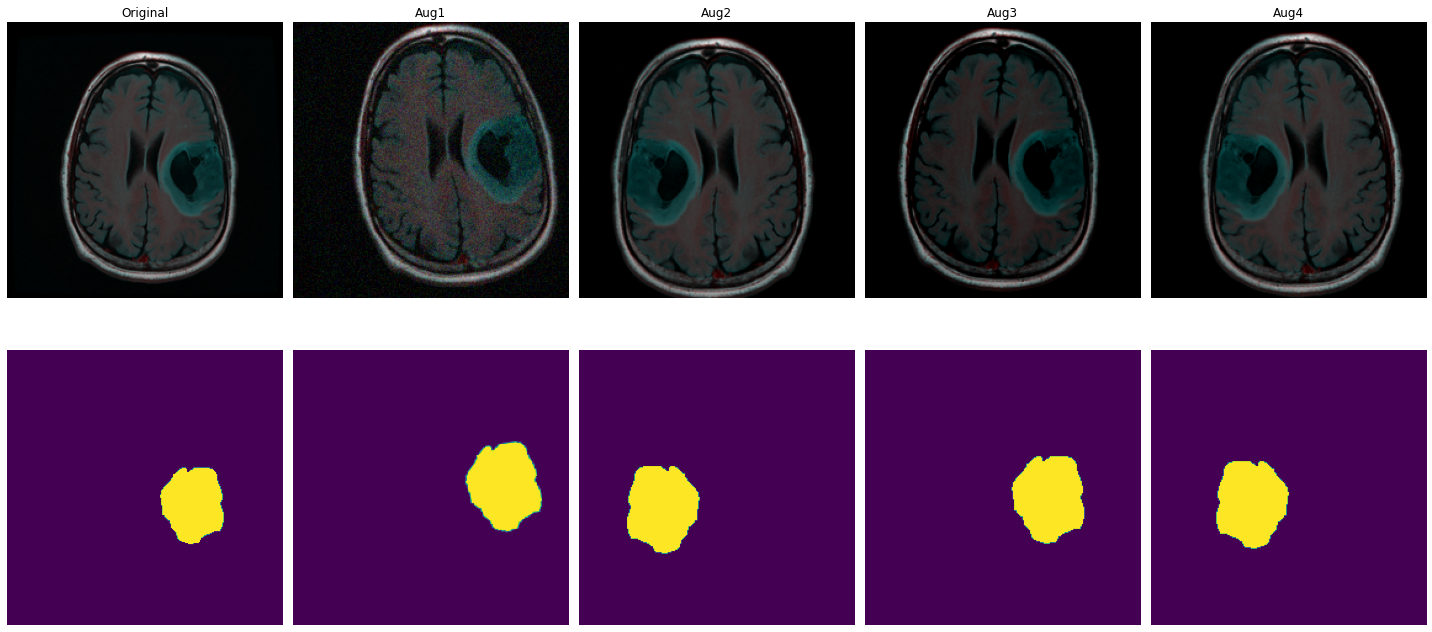

In [34]:
plot_monai_pipeline_data(test_slice, train_transforms)

### Moving data to GPU
MONAI has a really nice option that allows us to move the data to the GPU as part of this pipeline. Putting the data on GPU can save significant time during training, as it doesn't need to keep moving the data between RAM and the GPU. You can visit this [tutorial](https://github.com/Project-MONAI/tutorials/blob/main/acceleration/fast_model_training_guide.md) to learn different methods that can be used in MONAI to speed up model training.

The transformation pipeline has been included in the `monai_transformations()` function in `sagemaker_src/brain_datamodule`. The code for this is printed below. Here we can see that it has an optional input argument called `fast-mode`. If this is set to True, the `ToDeviced` class from MONAI is used to cache the transformed data until that point and moves the data onto the GPU device. This is a good option in this case as we have a small dataset. Also, it means that the steps prior to this (which are all deterministic) don't need to be repeated on every epoch. Note that steps that are random in nature (stochastic) need to come after the `ToDeviced` entry in the pipeline. The MONAI transformations have been designed to be able to be run on GPU, so these random processes (e.g. random crop, amplitude shifts) will be applied on each epoch.

In [8]:
??monai_transformations

Signature: monai_transformations(fast_mode: bool = False, device: str = 'cuda:0') -> Tuple[monai.transforms.compose.Compose, monai.transforms.compose.Compose]
Source:   
def monai_transformations(
    fast_mode: bool = False, device: str = "cuda:0"
) -> Tuple[Compose, Compose]:
    """Creates data transformation pipelines for Monai.

    Args:
        fast_mode (bool, optional): Whether training is run in fast mode with all data moved to GPU. Defaults to False.
        device (str, optional): Device where training will be run. Defaults to "cuda:0".

    Returns:
        Tuple[Compose, Compose]: A tuple of Monai Compose transforms for training and validation data.
    """
    # TRAINING TRANSFORMS
    train_transforms = [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        ScaleIntensityRanged(
            keys=["image", "mask"],
            a_min=0.0,
            a_max=255.0,
            b_min=0.0,
            b_max=1.0,
        ),
 

## Model training code
In this project I'm using PyTorch Lightning, a framework built on top of PyTorch, to help organize and structure the code for model training. This consists of three main components: 
- The `LightningDataModule`
- The `LightningModule`
- The PyTorch Lightning `Trainer`


### PyTorch Lightning datamodule
This is a Python class used to organize things related to data loading and processing (such as PyTorch Datasets and DataLoaders). My dataloader class (named `BrainMRIData`) can be found in the `/sagemaker_src/brain_datamodule` file. The code is printed out below.

In [5]:
??BrainMRIData

Init signature:
BrainMRIData(
    train_data_dir: Union[str, pathlib.Path],
    val_data_dir: Union[str, pathlib.Path],
    train_transforms: monai.transforms.compose.Compose,
    val_transforms: monai.transforms.compose.Compose,
    cache_rate: Union[float, NoneType] = 1.0,
    num_workers: Union[int, NoneType] = 8,
    batch_size: Union[int, NoneType] = 16,
    fast_mode: Union[bool, NoneType] = False,
)
Source:        
class BrainMRIData(pl.LightningDataModule):
    """PyTorch Lightning datamodule that encapsulates all the data loading and proceessing steps."""

    def __init__(
        self,
        train_data_dir: Union[str, pathlib.Path],
        val_data_dir: Union[str, pathlib.Path],
        train_transforms: monai.transforms.Compose,
        val_transforms: monai.transforms.Compose,
        cache_rate: Optional[float] = 1.0,
        num_workers: Optional[int] = 8,
        batch_size: Optional[int] = 16,
        fast_mode: Optional[bool] = False,
    ):
        """
        Arg

Note that the MONAI class `CacheDataset` is used to load the datasets. This has the option to set the `cache_rate`, which is the proportion of the data that will be red into memory. Here I set the default to 1.0 (i.e. the full dataset is read into memory) since we have a small dataset. This speeds up training as we don't have to keep on reading data from disk. If you have memory issues you can lower this value.

### PyTorch Lightning model module

The `LightningModule` class inherits everything from `torch.nn.Module` and adds many more useful features in top. Here we can configure what happens during training and validation steps, withoyt having to write all of the normal code that does things such as clearing the gradients, running back propagation and updating parameters (these are all taken care of for us). My code is contained in the `BrainMRIModel` class which is printed below:

In [6]:
??BrainMRIModel

Init signature:
BrainMRIModel(
    model_type: Union[str, NoneType] = 'unet',
    learning_rate: Union[float, NoneType] = 0.001,
    batch_size: Union[int, NoneType] = 16,
    dropout_rate: Union[float, NoneType] = 0.1,
    num_filters_block_1: Union[int, NoneType] = 16,
)
Source:        
class BrainMRIModel(pl.LightningModule):
    """PyTorch Lightning module to organize code for training model."""

    def __init__(
        self,
        model_type: Optional[str] = "unet",
        learning_rate: Optional[float] = 0.001,
        batch_size: Optional[int] = 16,
        dropout_rate: Optional[float] = 0.1,
        num_filters_block_1: Optional[int] = 16,
    ):
        """_summary_

        Args:
            model_type (Optional[str], optional): Model architecture to use. Either 'unet' or 'unet-attention'. Defaults to 'unet'.
            learning_rate (Optional[float], optional): Optimizer learning rate. Defaults to 0.001.
            batch_size (Optional[int], optional): dataloader bat

#### Model architecture
Note that my code currently has the option to use two different architectures from the MONAI framework. These are the standard UNet and the Attention UNet architectures. Originally I planned to pass whatever network you wanted to use as an input when creating an instance of the `BrainMRIModel` class, but this became problematic when trying to load the checkpoints inside SageMaker for deployment.

#### Loss function and metric
In this example I'm using the Dice Focal loss from MONAI as my loss function. This returns the weighted sum of the Dice and Focal losses and can help in situations of class imbalance, as encountered in this dataset. The Dice score is used as the metric for the validation data.

## Train model
Now we'll look at different ways we can train models using SageMaker. Depending on your setup and where you are running this notebook from, you'll only be able to run some of these options.

### Local training mode
Running things on AWS is very frustrating while you are developing the code. You need to wait for the EC2 instance to start and the training environment to be configured (including downloading of the Docker image and training data). You also need to pay for the compute time (which includes the setup time). Therefore it is much more convenient to develop things in a local environment which mimics running on an EC2 instance. For this AWS have made available the `local mode` for running SageMaker Estimators. 

**Note:** To be able to run things locally you need to have set up your local enviornment, which includes installing Docker Compose. Please see the project README file for basic instructions. If you haven't done this then you can skip this setp.


#### SageMaker settings
To run things locally you need to be careful with the arguments that are passed to the `PyTorch Estimator` object. To make things easier, I've included the `set_sagemaker_settings` function which will automatically generate these based on the `run_mode` we select. 

There are two modes where we run everything (including the training) locally. These are `local-all` (training runs on CPU) and `local-all-gpu` (training on GPU).


In [44]:
sagemaker_settings = set_sagemaker_settings(run_mode='local-all-gpu')
sagemaker_settings

{'sagemaker_session': <sagemaker.local.local_session.LocalSession at 0x7f2e54d17fd0>,
 'role_arn': 'arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-20200101T000001',
 'training_input_path': 'file:///home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/data/brain-mri-dataset/train',
 'validation_input_path': 'file:///home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/data/brain-mri-dataset/val',
 'output_path': 'file:///home/robsmith155/github/udacity-nd-aws-ml-engineer-final-project/sagemaker_outputs/',
 'instance_type': 'local_gpu',
 'use_spot_instances': False,
 'max_run': None,
 'max_wait': None,
 'checkpoint_s3_uri': None,
 'base_job_name': 'brain-mri-segmentation'}

A few things to note here:
- **sagemaker_session**: Here we can create a local session object using `sagemaker.LocalSession()`. Note that we need to configure it with `sagemaker_session.config = {"local": {"local_code": True}`. See [here](https://sagemaker.readthedocs.io/en/stable/overview.html#local-mode) for more details.
- **role_arn**: When running everything locally, we can just use a dummy role ARN. The one given here does not exist in my AWS account.
- **training_input_path**: This points to a file on the local machine.
- **instance_type**: To run on CPU this would be set to `local`, while for GPU training it is `local_gpu`.
- **output_path:** The output path is a local file directory.

Now we can use these settings to create an instance of the SageMaker `PyTorch` estimator class. 

In [45]:
estimator = PyTorch(
    entry_point='train.py',
    source_dir='./../sagemaker_src',
    role=sagemaker_settings['role_arn'],
    py_version='py38',
    framework_version='1.11.0',
    instance_type=sagemaker_settings['instance_type'],
    instance_count=1,
    use_spot_instances=sagemaker_settings['use_spot_instances'],
    max_run=sagemaker_settings['max_run'],
    max_wait=sagemaker_settings['max_wait'],
    sagemaker_session=sagemaker_settings['sagemaker_session'],
    output_path=sagemaker_settings['output_path'],
    checkpoint_s3_uri=sagemaker_settings['checkpoint_s3_uri'],
    base_job_name=sagemaker_settings['base_job_name'],
    hyperparameters={
        'model_type': 'unet',
        'max_epochs': 10,
        'lr': 0.001,
        'batch_size': 16,
        'fast_mode': 'True',
        'dropout_rate': 0.1
    }
    )

A few additional notes here:
- **entry_point**: This is the name of the script that will be launched inside the AWS SagemMaker Docker container. 
- **source_dir**: This is the path to the folder containing all the files that are needed by the Docker container to run the training. This is the path where the `entry_point` script is located. In my repo I put all these files in a folder named `sagemaker_src`.
- **hyperparameters:** Here we pass a dictionary of key-value pairs corresponding to the arguments in the `train.py` entry point script. 

**Note:** We cannot pass Boolean arguments with Argparse to SageMaker. Instead I had to include a `str2bool` function which will convert a string such as 'true' to a Boolean value.

Now let's fit the model. 

In [46]:
estimator.fit({'train': sagemaker_settings['training_input_path'], 'val': sagemaker_settings['validation_input_path']}, wait=True)

2022-08-18 13:18:53,962 Defaulting to the only supported framework/algorithm version: latest.
2022-08-18 13:18:53,974 Ignoring unnecessary instance type: None.
2022-08-18 13:18:53,975 image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
2022-08-18 13:18:53,985 Creating training-job with name: brain-mri-segmentation-2022-08-18-10-18-53-960
2022-08-18 13:18:53,987 Starting training job
2022-08-18 13:18:53,997 Found credentials in shared credentials file: ~/.aws/credentials
2022-08-18 13:18:53,998 Using the long-lived AWS credentials found in session
2022-08-18 13:18:54,001 docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-au0p9:
    command: train
    container_name: w7xaclv0ji-algo-1-au0p9
    environment:
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    - '[Masked]'
    image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.11.0-gpu-py38
    networks:
      sagemaker-local:
        al

Creating w7xaclv0ji-algo-1-au0p9 ... 
Creating w7xaclv0ji-algo-1-au0p9 ... done
Attaching to w7xaclv0ji-algo-1-au0p9
w7xaclv0ji-algo-1-au0p9 | 2022-08-18 10:18:55,869 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
w7xaclv0ji-algo-1-au0p9 | 2022-08-18 10:18:55,893 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
w7xaclv0ji-algo-1-au0p9 | 2022-08-18 10:18:55,893 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
w7xaclv0ji-algo-1-au0p9 | 2022-08-18 10:18:55,897 sagemaker_pytorch_container.training INFO     Invoking user training script.
w7xaclv0ji-algo-1-au0p9 | 2022-08-18 10:18:55,898 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
w7xaclv0ji-algo-1-au0p9 | /opt/conda/bin/python3.8 -m pip install -r requirements.txt
w7xaclv0ji-algo-1-au0p9 | Collecting monai[all]
w7xaclv0ji-algo-1-au0p9 | Downloading monai-0.9.1-202207251608-py3-non

As mentioned before, this option is great to use while developing and debugging. To make things even faster, it would be best to create a custom container image with the additional Python dependencies already included so it doesn't need to install these everytime.

### Local submit mode
**Note:** To run this mode, you need to be running the notebook from your own machine with the AWS CLI configured.

In this case, I'm running the notebook from my own laptop, but submit the `Training Job` to be run on AWS. To get the settings for this mode, use `run_mode=local-submit`.

When you execute the function below, you will be prompted to enter the name of the SageMaker execution role name to use. The function will then get the corresponding role ARN.

In [47]:
sagemaker_settings = set_sagemaker_settings(run_mode='local-submit', instance_type='ml.p2.xlarge')
sagemaker_settings

2022-08-18 13:33:49,516 Found credentials in shared credentials file: ~/.aws/credentials


{'sagemaker_session': <sagemaker.session.Session at 0x7f2e9f152f10>,
 'role_arn': 'arn:aws:iam::377574710449:role/service-role/AmazonSageMaker-ExecutionRole-20220215T183023',
 'training_input_path': 's3://sagemaker-brain-mri/data/train',
 'validation_input_path': 's3://sagemaker-brain-mri/data/val/',
 'output_path': 's3://sagemaker-brain-mri/outputs',
 'instance_type': 'ml.p2.xlarge',
 'use_spot_instances': True,
 'max_run': 3600,
 'max_wait': 7200,
 'checkpoint_s3_uri': 's3://sagemaker-brain-mri/checkpoints',
 'base_job_name': 'brain-mri-segmentation'}

Some things to note in this case:
- **sagemaker_session:** Now we create an active session with SageMaker.
- **role_arn:** Now we need to use an actual role ARN that exists in our AWS account with sufficient permissions. When you execute the function above, you will be prompted to enter the name of the SageMaker execution role to use. The function will then get the corresponding role ARN.
- **training_input_path:** Now instead of passing the local file folders, we specify the S3 buckets where we copied the data earlier.
- **instance_type:** You may need to change the instance type to something that you have access to (or contact AWS support to increase your quota)


In [50]:
estimator = PyTorch(
    entry_point='train.py',
    source_dir='./../sagemaker_src',
    role=sagemaker_settings['role_arn'],
    py_version='py38',
    framework_version='1.11.0',
    instance_type=sagemaker_settings['instance_type'],
    instance_count=1,
    use_spot_instances=sagemaker_settings['use_spot_instances'],
    max_run=sagemaker_settings['max_run'],
    max_wait=sagemaker_settings['max_wait'],
    sagemaker_session=sagemaker_settings['sagemaker_session'],
    output_path=sagemaker_settings['output_path'],
    checkpoint_s3_uri=sagemaker_settings['checkpoint_s3_uri'],
    base_job_name=sagemaker_settings['base_job_name'],
    hyperparameters={
        'model_type': 'unet',
        'max_epochs': 2,
        'lr': 0.001,
        'batch_size': 16,
        'fast_mode': 'True',
        'dropout_rate': 0.1
    }
    )

Note here that I'm just running the training for two epochs as a demonstration that it works. As we will see, it is not worth running this on SageMaker.

In [51]:
estimator.fit({'train': sagemaker_settings['training_input_path'], 'val': sagemaker_settings['validation_input_path']}, wait=True)

2022-08-18 13:34:48,217 Defaulting to the only supported framework/algorithm version: latest.
2022-08-18 13:34:48,227 Ignoring unnecessary instance type: None.
2022-08-18 13:34:48,228 image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
2022-08-18 13:34:48,238 Creating training-job with name: brain-mri-segmentation-2022-08-18-10-34-42-896


2022-08-18 10:34:50 Starting - Starting the training job...
2022-08-18 10:35:15 Starting - Preparing the instances for trainingProfilerReport-1660818888: InProgress
............
2022-08-18 10:37:31 Downloading - Downloading input data.........
2022-08-18 10:39:12 Training - Downloading the training image.......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-18 10:43:43,224 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-18 10:43:43,250 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-18 10:43:43,260 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-18 10:43:45,133 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.7/990.7 kB 31.8 MB/s 

If submitted successfully, you should now see a SageMaker Training Job has been created under your account. For example:

<p align="center">
    <img src="./../imgs/local-submit-training-job.png">
</p>


An important point to make here is how slow training is on the AWS EC2 instance, despite running on a better GPU than I have on my laptop. Running on my laptop (with NVIDIA 3070 GPU), each epoch takes around 30 seconds (see test above). However, with exactly the same settings, an epoch takes around 90 seconds on an `ml.p2.xlarge` instance (which uses an NVIDIA Tesla V100 GPU). So despite having a much better GPU, training takes three times as long?

### SageMaker notebook submission
The final method of submitting a Training Job is when running a notebook from within SageMaker. Here the settings are similar to the `local-submit` method, except that we can automatically retrieve the role ARN from the SageMaker session running the notebook.

In [ ]:
#sagemaker_settings = set_sagemaker_settings(run_mode='sagemaker', instance_type='ml.p2.xlarge')
#sagemaker_settings

In [ ]:
# estimator = PyTorch(
#     entry_point='train.py',
#     source_dir='./../sagemaker_src',
#     role=sagemaker_settings['role_arn'],
#     py_version='py38',
#     framework_version='1.11.0',
#     instance_type=sagemaker_settings['instance_type'],
#     instance_count=1,
#     use_spot_instances=sagemaker_settings['use_spot_instances'],
#     max_run=sagemaker_settings['max_run'],
#     max_wait=sagemaker_settings['max_wait'],
#     sagemaker_session=sagemaker_settings['sagemaker_session'],
#     output_path=sagemaker_settings['output_path'],
#     checkpoint_s3_uri=sagemaker_settings['checkpoint_s3_uri'],
#     base_job_name=sagemaker_settings['base_job_name'],
#     hyperparameters={
#         'model_type': 'unet',
#         'max_epochs': 2,
#         'lr': 0.001,
#         'batch_size': 16,
#         'fast_mode': 'True',
#         'dropout_rate': 0.1
#     }
#     )

In [ ]:
# estimator.fit({'train': sagemaker_settings['training_input_path'], 'val': sagemaker_settings['validation_input_path']}, wait=True)

## Hyperparameter search
The `HyperParameterTuner` class from the SageMaker SDK cannot be run locally. Therefore we must submit the jobs to be run on AWS. Here I will just run a quick example to demonstrate the process. As highlighted in the previous sections, it takes a long time to set up an EC2 instance and run the training job on AWS compared to just running locally. Therefore in the next notebook I will show how to run a hyperparameter search locally and then deploy the best model to SageMaker.

**Note:** If running from a SageMaker Notebook, you need to change the run mode below to `sagemaker`

In [52]:
sagemaker_settings = set_sagemaker_settings(run_mode='local-submit', instance_type='ml.p2.xlarge', use_spot_instances=True)

In [ ]:
estimator = PyTorch(
    entry_point='train.py',
    source_dir='./../sagemaker_src',
    role=sagemaker_settings['role_arn'],
    py_version='py38',
    framework_version='1.11.0',
    instance_type=sagemaker_settings['instance_type'],
    instance_count=1,
    use_spot_instances=sagemaker_settings['use_spot_instances'],
    max_run=sagemaker_settings['max_run'],
    max_wait=sagemaker_settings['max_wait'],
    sagemaker_session=sagemaker_settings['sagemaker_session'],
    output_path=sagemaker_settings['output_path'],
    checkpoint_s3_uri=sagemaker_settings['checkpoint_s3_uri'],
    base_job_name=sagemaker_settings['base_job_name'],
    hyperparameters={
        'model_type': 'unet',
        'max_epochs': 10,
        'wandb_tracking': 'True',
        'wandb_run_base_name': 'aws-tuning-test',
        'fast_mode': 'True'
    }
)

Note that I've included an option to track experiments with Weights and Biases, which can be turned on by setting the `wandb_tracking` parameter to True in the hyperparameters. This will log the losses and metrics during training, the system properties (e.g. CPU and GPU usage) and best model from the training run. I also create a custom PyTorch Lightning callback (`BrainSegPredictionLogger`) that will generate predictions for a sample of the validation slices and save them as a Weights and Biases Table. To save unnecessary computation and memory usage, this has been set to only run if the validation score improved in the current epoch.

Now we define the hyperparameter search space, which includes the learning rate, batch size, dropout arte and number of filters in the first block of the network.

In [53]:
# Hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.00001, 0.1),
    "batch_size": CategoricalParameter([16,32]),
    "dropout_rate": ContinuousParameter(0.0, 0.3),
    "num_filters_block_1": CategoricalParameter([16,32,64])
}

We also need to tell SageMaker how to extract the metric from the log files. the code below tells it to look for entries of the form `Val_dice=(.*?);` in the log files which are sent to CloudWatch. 

In [54]:
objective_metric_name = "validation:dice"
objective_type = "Maximize"
metric_definitions=[
       {'Name': 'validation:dice', 'Regex': 'Val_dice=(.*?);'}
    ]

Now we create an instance of `HyperparameterTuner`. Here I will just train two different models to demonstrate how this works. To run a proper hyperparameter search you can increase the `max_jobs` parameter. 

In [55]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name='hpo-brain-mri-test'
)

Now we submit the tuning job to AWS SageMaker:

In [56]:
tuner.fit({'train': sagemaker_settings['training_input_path'], 'val': sagemaker_settings['validation_input_path']}, wait=True)

2022-08-18 13:59:43,833 Defaulting to the only supported framework/algorithm version: latest.
2022-08-18 13:59:43,842 Ignoring unnecessary instance type: None.
2022-08-18 13:59:44,967 image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
2022-08-18 13:59:44,978 Creating hyperparameter tuning job with name: hpo-brain-mri-test-220818-1359


.......................................................................................................................................................................................................................................................................................................................................................................................................................................!


If this is successful, you should see that a Hyperparameter Tuning Job has been created in your AWS account (such as shown below).
<p align="center">
    <img src="./../imgs/local-submit-hpo-tuning.png">
</p>

### Deploy best model
Of course, we wouldn't normally run just two trials in the hyperparameter search and then deploy that model. But we will do that here just to illustrate the process. For much larger datasets it would make sense to run the search on AWS, but in this case it doesn't.

In [58]:
tuner._current_job_name

'hpo-brain-mri-test-220818-1359'

In [59]:
tuner_analyze = sagemaker.HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=tuner._current_job_name)

In [60]:
tuner_analyze.dataframe()

,batch_size,dropout_rate,lr,num_filters_block_1,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""16""",0.183890,0.000269,"""16""",hpo-brain-mri-test-220818-1359-002-b662c869,Completed,0.060291,2022-08-18 14:22:03+03:00,2022-08-18 14:34:28+03:00,745.0
1,"""32""",0.260682,0.036142,"""64""",hpo-brain-mri-test-220818-1359-001-cc431621,Completed,0.671853,2022-08-18 14:01:45+03:00,2022-08-18 14:17:45+03:00,960.0


In [61]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2022-08-18 11:17:45 Starting - Preparing the instances for training
2022-08-18 11:17:45 Downloading - Downloading input data
2022-08-18 11:17:45 Training - Training image download completed. Training in progress.
2022-08-18 11:17:45 Uploading - Uploading generated training model
2022-08-18 11:17:45 Completed - Training job completed


2022-08-18 14:42:04,456 Creating model with name: hpo-brain-mri-test-2022-08-18-11-38-51-073
2022-08-18 14:42:06,110 Creating endpoint-config with name hpo-brain-mri-test-220818-1359-001-cc431621
2022-08-18 14:42:06,364 Creating endpoint with name hpo-brain-mri-test-220818-1359-001-cc431621


---------------!

If successful, you should see that you now have an endpoint created in SageMaker:
<p align="center">
    <img src="./../imgs/sagemaker-hpo-deployed-endpoint.png">
</p>

In [62]:
predictor.endpoint_name

'hpo-brain-mri-test-220818-1359-001-cc431621'

### Make endpoint prediction
Now let's test that we can make a prediction using the deployed endpoint.

In [65]:
val_patient_folders = [f.path for f in os.scandir(os.path.join(DATA_ROOT_PATH, 'brain-mri-dataset/val')) if f.is_dir()]
patient1 = extract_patient_filepaths(val_patient_folders[0])

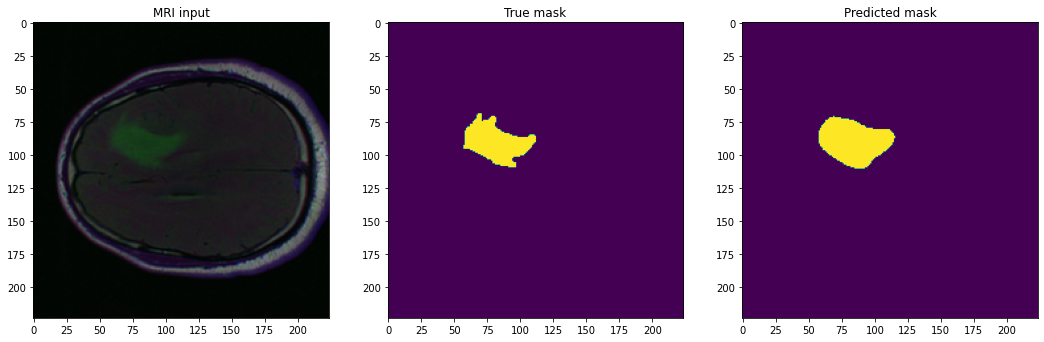

In [76]:
plot_endpoint_prediction(predictor, image_path=patient1[20]['image'], mask_path=patient1[20]['mask'])

And a different slice:

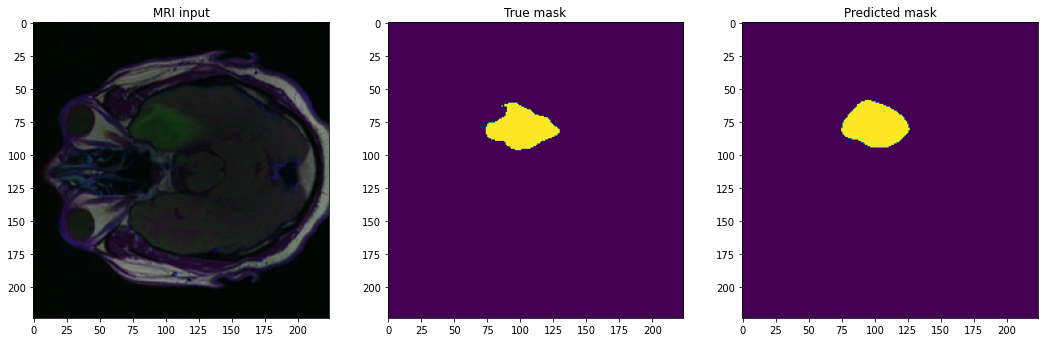

In [78]:
plot_endpoint_prediction(predictor, image_path=patient1[10]['image'], mask_path=patient1[10]['mask'])

Before finishing, make sure you delete the endpoint:

In [79]:
predictor.delete_endpoint()

2022-08-18 15:15:48,676 Deleting endpoint configuration with name: hpo-brain-mri-test-220818-1359-001-cc431621
2022-08-18 15:15:48,994 Deleting endpoint with name: hpo-brain-mri-test-220818-1359-001-cc431621


In the next notebook, we will see how we can run a local hyperparameter search using the [Optuna](https://optuna.org/) package and deploy the best model to SageMaker.